# EDA

In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [55]:
plt.rcParams.update({'font.size': 16})

In [3]:
from pathlib import Path
DATA_DIR = Path("/media/pawel/KIOXIA/google")

In [4]:
review_files = list(DATA_DIR.glob("review-*.json"))

In [5]:
states = [re.findall(r"review-(.*?).json", str(x))[0] for x in review_files]

In [6]:
len(states)

52

In [7]:
def count_lines(fname):
    with open(fname) as f:
        return sum(1 for _ in f)

In [8]:
entry_counts = pd.DataFrame([{
    "state": state,
    "reviews": count_lines(DATA_DIR / f"review-{state}.json"),
    "meta": count_lines(DATA_DIR / f"meta-{state}.json")
    } for state in tqdm(states)]
)

100%|███████████████████████████████████████████| 52/52 [03:09<00:00,  3.64s/it]


## Count of reviews and meta per state

In [9]:
entry_counts

,state,reviews,meta
0,North Dakota,1109558,11987
1,Georgia,24060125,166381
2,Arizona,18375050,108579
3,California,70529977,515961
4,Mississippi,3861771,37147
5,Massachusetts,10447007,92520
6,Rhode Island,1777094,15941
7,Kentucky,7654993,63193
8,Idaho,3892636,33214
9,New Mexico,4705389,34703


In [10]:
entry_counts["reviews"].sum()

666324103

In [11]:
entry_counts["meta"].sum()

4989684

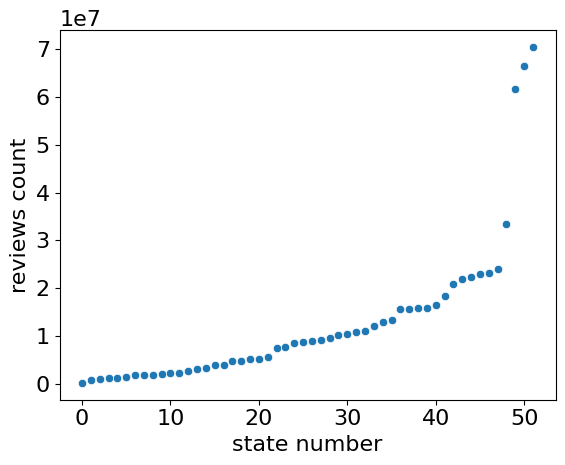

In [56]:
sns.scatterplot(sorted(entry_counts["reviews"]))
plt.xlabel("state number")
plt.ylabel("reviews count")
plt.savefig("./plots/state-review-count.eps", format="eps", bbox_inches='tight')

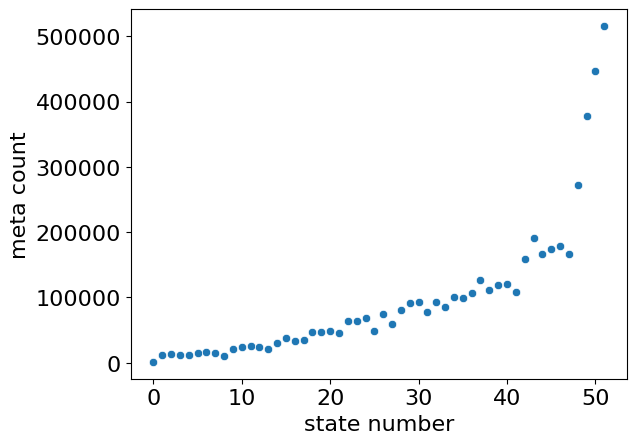

In [57]:
sns.scatterplot([x for _, x in sorted(zip(entry_counts["reviews"], entry_counts["meta"]), key=lambda pair: pair[0])]
)
plt.xlabel("state number")
plt.ylabel("meta count")
plt.savefig("./plots/state-meta-count.eps", format="eps", bbox_inches='tight')

In [14]:
entry_counts.sort_values("reviews", ascending=False).head(5)

,state,reviews,meta
3,California,70529977,515961
18,Texas,66435184,447314
49,Florida,61803524,378020
16,New York,33459761,272189
1,Georgia,24060125,166381


In [15]:
entry_counts.sort_values("meta", ascending=False).head(5)

,state,reviews,meta
3,California,70529977,515961
18,Texas,66435184,447314
49,Florida,61803524,378020
16,New York,33459761,272189
44,Pennsylvania,21944802,190816


## Reading the reviews

In [16]:
from dask.distributed import Client
import logging
client = Client(silence_logs=logging.ERROR, n_workers=8)

In [17]:
client.dashboard_link

'http://127.0.0.1:8787/status'

In [18]:
import dask.dataframe as dd

In [19]:
def read_json_user_id_str(*args, **kwargs):
    df = pd.read_json(*args, **kwargs, dtype={"user_id": str})
    return df

In [20]:
reviews = dd.read_json(DATA_DIR / "review-*.json", lines=True, 
                       blocksize="32 MiB", engine=read_json_user_id_str)

In [21]:
reviews.npartitions

6253

In [22]:
reviews.columns

Index(['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id'], dtype='object')

In [23]:
reviews.dtypes

user_id    object
name       object
time        int64
rating      int64
text       object
pics       object
resp       object
gmap_id    object
dtype: object

## Number of users

**Uwaga!** Kolumna `user_id` zawiera nulle!

In [24]:
# reviews["user_id"].nunique().compute()

## Ratings distribution

In [26]:
rating_counts = reviews.groupby("rating")["rating"].count().compute()
rating_counts

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7fa0b266e560>
Traceback (most recent call last):
  File "/home/pawel/miniconda3/envs/dask/lib/python3.10/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt

Task exception was never retrieved
future: <Task finished name='Task-626' coro=<Client._gather.<locals>.wait() done, defined at /home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/distributed/client.py:2173> exception=AllExit()>
Traceback (most recent call last):
  File "/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/distributed/client.py", line 2182, in wait
    raise AllExit()
distributed.client.AllExit


In [ ]:
rating_counts[rating_counts.index < 3.5].sum()

In [ ]:
rating_counts[rating_counts.index >= 3.5].sum()

In [ ]:
rating_counts.to_frame(name="count").reset_index()

In [27]:
rating_counts=pd.DataFrame({"rating": [1, 2, 3, 4, 5], "count": [
    47614525, 21466406, 52491124, 120256559, 420254855
]})

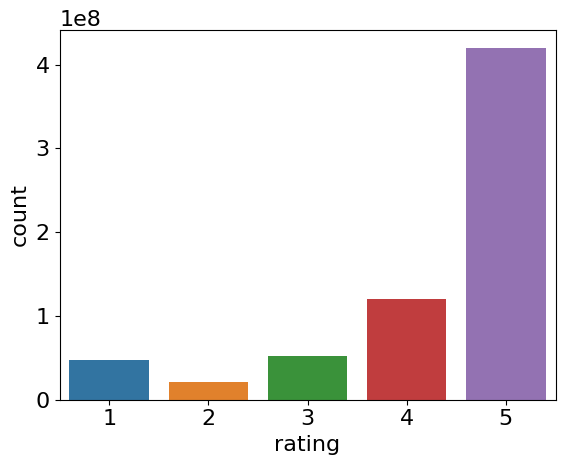

In [58]:
sns.barplot(rating_counts, x="rating", y="count")
plt.xlabel("rating")
plt.ylabel("count")
plt.savefig("./plots/rating-count.eps", format="eps", bbox_inches='tight')

In [37]:
rating_counts

,rating,count
0,1,47614525
1,2,21466406
2,3,52491124
3,4,120256559
4,5,420254855


In [38]:
rating_counts

,rating,count
0,1,47614525
1,2,21466406
2,3,52491124
3,4,120256559
4,5,420254855


In [39]:
rating_counts_split = rating_counts.set_index("rating").groupby(lambda x: "rating<3.5" if x < 3.5 else "rating>3.5").sum()
rating_counts_split

,count
rating,
rating<3.5,121572055
rating>3.5,540511414


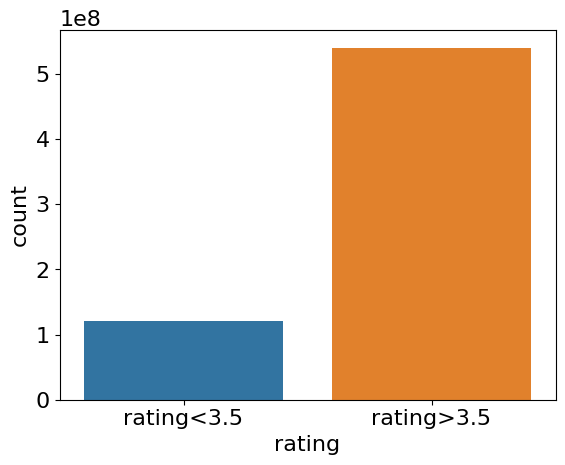

In [59]:
sns.barplot(rating_counts_split.reset_index(), x="rating", y="count")
plt.xlabel("rating")
plt.ylabel("count")
plt.savefig("./plots/rating-split-count.eps", format="eps", bbox_inches='tight')

## String length of user_id

In [ ]:
user_id_len_histogram = reviews["user_id"].str.len().value_counts().compute()

In [ ]:
user_id_len_histogram

## String length of gmap_id

In [ ]:
gmap_id_len_histogram = reviews["gmap_id"].str.len().value_counts().compute()

In [ ]:
gmap_id_len_histogram

## Meta

In [65]:
del reviews

NameError: name 'reviews' is not defined

In [66]:
from unidecode import unidecode

In [67]:
def read_json_add_state(*args, **kwargs):
    df = pd.read_json(*args, **kwargs)
    # add or drop necessary columns here
    df["state"] = df.get("state", None)
    df = df[['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude',
       'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC',
       'state', 'relative_results', 'url']]
    df["category"] = df["category"].apply(lambda x: list(map(unidecode, x)) if x else x)
    return df

In [68]:
import pandas as pd
meta = dd.read_json(DATA_DIR / "meta-*.json", lines=True, engine=read_json_add_state, blocksize="32 MiB")

In [69]:
meta.npartitions

146

## Nullable columns

In [70]:
meta.isnull().any().compute()

name                 True
address              True
gmap_id             False
description          True
latitude            False
longitude           False
category             True
avg_rating          False
num_of_reviews      False
price                True
hours                True
MISC                 True
state                True
relative_results     True
url                 False
dtype: bool

## Number of distinct categories and their individual counts

In [71]:
category_histogram = meta["category"].explode().value_counts().compute()

In [72]:
category_histogram

category
Restaurant                 332567
Fast food restaurant       150474
Auto repair shop           122044
Gas station                120180
Takeout Restaurant         101947
                            ...  
Pipe manufacturer               1
Freelance professionals         1
Citizens advice bureau          1
Citroen dealer                  1
Hobbies                         1
Name: count, Length: 4569, dtype: int64

## Most popular categories

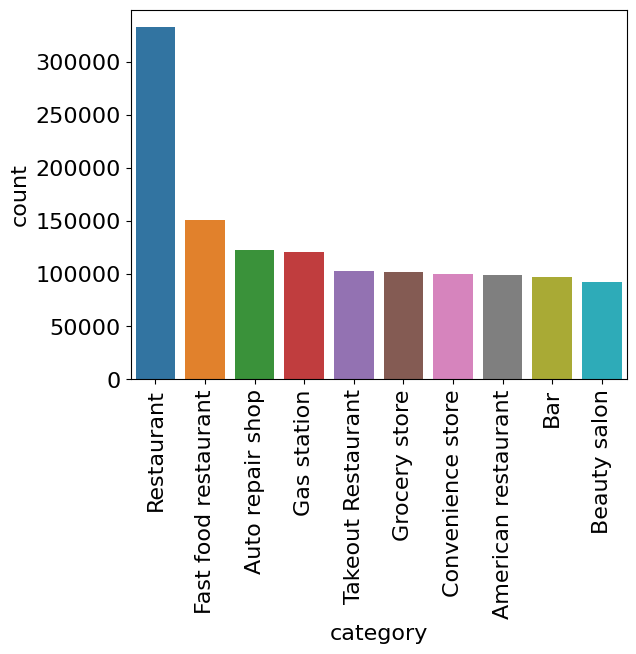

In [73]:
sns.barplot(category_histogram.sort_values(ascending=False).head(10).to_frame(name="count").reset_index(), x="category", y="count")
plt.xlabel("category")
plt.ylabel("count")
plt.xticks(rotation=90)
plt.savefig("./plots/category-count.eps", format="eps", bbox_inches='tight')

## Number of categories per item

In [74]:
num_categories_histogram = meta["category"].rename("num_categories").dropna().apply(len).value_counts().compute()

/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/dask/dataframe/core.py:4341: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('num_categories', 'int64'))

  warnings.warn(meta_warning(meta))
2023-09-15 10:12:07,697 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:34271
Traceback (most recent call last):
  File "/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most r

In [75]:
num_categories_histogram

num_categories
1     2642895
2      846624
3      451914
4      325893
5      279367
6      153747
7       95568
10      74671
8       55520
9       41361
11        798
12         97
13         59
14         20
15         13
16          6
17          3
18          3
19          1
21          1
22          1
23          1
32          1
Name: count, dtype: int64

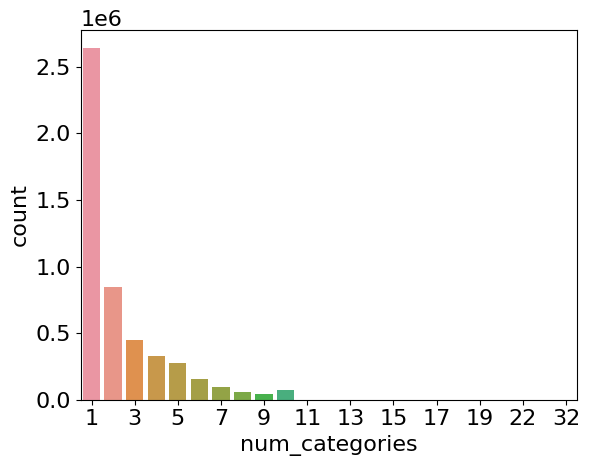

In [91]:
g = sns.barplot(num_categories_histogram.to_frame(name="count").reset_index(), x="num_categories", y="count")
g.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.savefig("./plots/num-categories-count.eps", format="eps", bbox_inches='tight')

## Categories merged as string

In [77]:
categories_as_str_len_histogram = meta["category"].rename("categories_merged_len").dropna().str.join('|').apply(len).value_counts().compute()

/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/dask/dataframe/core.py:4341: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('categories_merged_len', 'int64'))

  warnings.warn(meta_warning(meta))
2023-09-15 10:13:46,189 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:45341 -> tcp://127.0.0.1:42167
Traceback (most recent call last):
  File "/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

In [78]:
categories_as_str_len_histogram

categories_merged_len
11     258627
16     243993
10     242324
12     175458
18     168704
        ...  
287         1
284         1
283         1
282         1
468         1
Name: count, Length: 309, dtype: int64

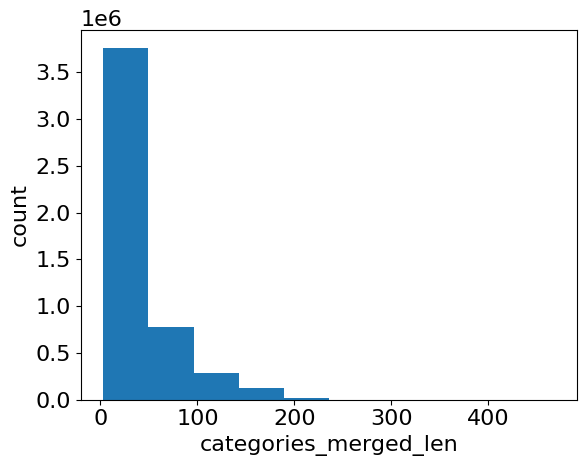

In [79]:
plt.hist(categories_as_str_len_histogram.index, bins=10, weights=categories_as_str_len_histogram)
plt.xlabel("categories_merged_len")
plt.ylabel("count")
plt.savefig("./plots/categories-as-str-len-count.eps", format="eps", bbox_inches='tight')

In [ ]:
categories_as_str_len_histogram.index.max()

2023-09-15 10:01:33,513 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:44287
Traceback (most recent call last):
  File "/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/distributed/comm/core.py", line 329, in connect
    handshake = await wait_for(comm.read(), time_left())
  File "/home/pawel/miniconda3/envs/dask/lib/python3.10/site-packages/distributed/utils.py", line 1849, in wait_for
    return await asyncio.wait_for(fut, timeout)
  File "/home/p

## Joining the dataframes

In [ ]:
import os
os.environ["DATA_DIR"] = str(DATA_DIR)

In [ ]:
# !python join_reviews_meta.py